In [210]:
name = "Detroit, Conant Street"
src = "detroit_conant"          # source of annotated data
feets_per_inch = 333.33         # scale of the map
n0 = 1                          # index of one node
n1 = "(2, 42.43049082474931, -83.07592347811368)"   # (index, lat, lon) of another node connected to n0
d_n0_n1 = 803.87                # distance between n0 and n1 in feet

Pois categories:
- entertainment
- commercial
- catering
- service
- office
- leisure
- natural
- education
- building.historic
- heritage
- tourism
- accomodation
- pet
- healthcare
- administrative
- production
- religion
- amenity
- public transport

Nodes features:
- crosswalk
- walk light
- round-about
- walk light duration
- street width
- tactile paving

Edges features:
- work in progress
- bike lane
- uphill
- surface
- one way
- tactile paving
- stairs

Pois features:
- wheelchair accessible
- tactile paving
- tactile map
- reception
- stairs
- elevators

In [211]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import json

In [212]:
out = f"{src}/{src}_out"

In [213]:
!python3.8 src/convert_new_york_pois.py  --src_dir "{src}" --name "{name}" --feets_per_inch {feets_per_inch}

Seed: 1728287810.039571
Street not found: West 31st Street
New York references found in Prosek
New York references found in Sunset Hotel


In [214]:
fixes = {
    "Cooper Electric": "Joseph Campau Avenue",
    "The Lincoln Detroit": "Klinger Street",
    "Urban Fusion": "East Robinwood Street",
    "Wells Fargo": "East Grixdale Avenue",
    "Whole Foods Market": "East Grixdale Avenue",
    "Wolfgang’s Steakhouse": "Brinker Avenue",
}

with open(f"{src}/pois.json") as f:
    pois_raw = json.load(f)

for poi in pois_raw["features"]:
    poi = poi["properties"]
    if not "name" in poi:
        continue

    if poi["name"] in fixes:
        if "branch" in poi and poi["branch"] == poi["street"]:
            poi["branch"] = fixes[poi["name"]]
        poi["street"] = fixes[poi["name"]]

with open(f"{src}/pois.json", "w") as f:
    json.dump(pois_raw, f, indent=4)

In [215]:
!python3.8 src/format.py --name "{name}" --n0 {n0} --n1 "{n1}" --d_feets {d_n0_n1} --feets_per_inch {feets_per_inch} --src_dir "{src}"

Seed: 1728542361.382921
Feets per pixel: 2.42059254136372
Skipping POI without name at index 1
Skipping POI without name at index 3
Skipping POI without name at index 5
Skipping POI without name at index 8
Skipping POI without name at index 12
Could not find edge for Wells Fargo
Could not find edge for Urban Fusion
Jewelry Shopping Mall (18) is too close to node 5
Valley Bank (46) is too close to node 7
Stavros Niarchos Foundation Library (37) is too close to node 23
Antioch Missionary Baptist Church (1) is too close to node 25
Dig (11) is too close to node 27
Poké Bar (29) is too close to node 30
Blank Slate Coffee + Kitchen (5) is too close to node 46
American Academy of Dramatic Arts (0) is too close to Prosek (30)
Conant Ave United Methodist Church (8) is too close to Dig (11)
Conant Gardens Church of Christ (9) is too close to Silver Creek (34)
Cooper Electric (10) is too close to Tofu House (44)
Cooper Electric (10) is too close to United Grill Coney Island (45)
Keynote Lounge (1

In [216]:
def distance(p1, p2):
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

def get_label(name: str):
    name.replace("-", " ")
    name.replace("_", " ")

    label = ""
    for word in name.split(" "):
        if len(word) > 2 and word[:-2].isnumeric():
            label += word[:-2]
        else: label += word[0]
    return label

def get_contrasting_color(color):
    rgb = mcolors.to_rgb(color)
    brightness = 0.299 * rgb[0] + 0.587 * rgb[1] + 0.114 * rgb[2]
    return 'white' if brightness < 0.5 else 'black'

In [217]:
G = nx.Graph()

with open(f'{out}/nodes.json') as f:
    nodes = json.load(f)

for i, node in enumerate(nodes):
    G.add_node(i, pos=(node[0], node[1]))

with open(f'{out}/edges.json') as f:
    edges = json.load(f)

with open(f'{out}/streets.json', 'r') as f:
    streets = json.load(f)

for street, street_edges in streets.items():
    street = street.replace("Street", "St")
    street = street.replace("Avenue", "Ave")
    street = street.replace("Boulevard", "Blvd")
    street = street.replace("Road", "Rd")

    for edge_index in street_edges:
        edge = edges[edge_index]

        n1 = G.nodes[edge[0]]['pos']
        n2 = G.nodes[edge[1]]['pos']
        dist = distance(n1, n2)
        G.add_edge(edge[0], edge[1], weight=dist, street=street)

with open(f'{out}/pois.json') as f:
    pois = json.load(f)

print(f"PoIs found: {len(pois)}")

PoIs found: 51


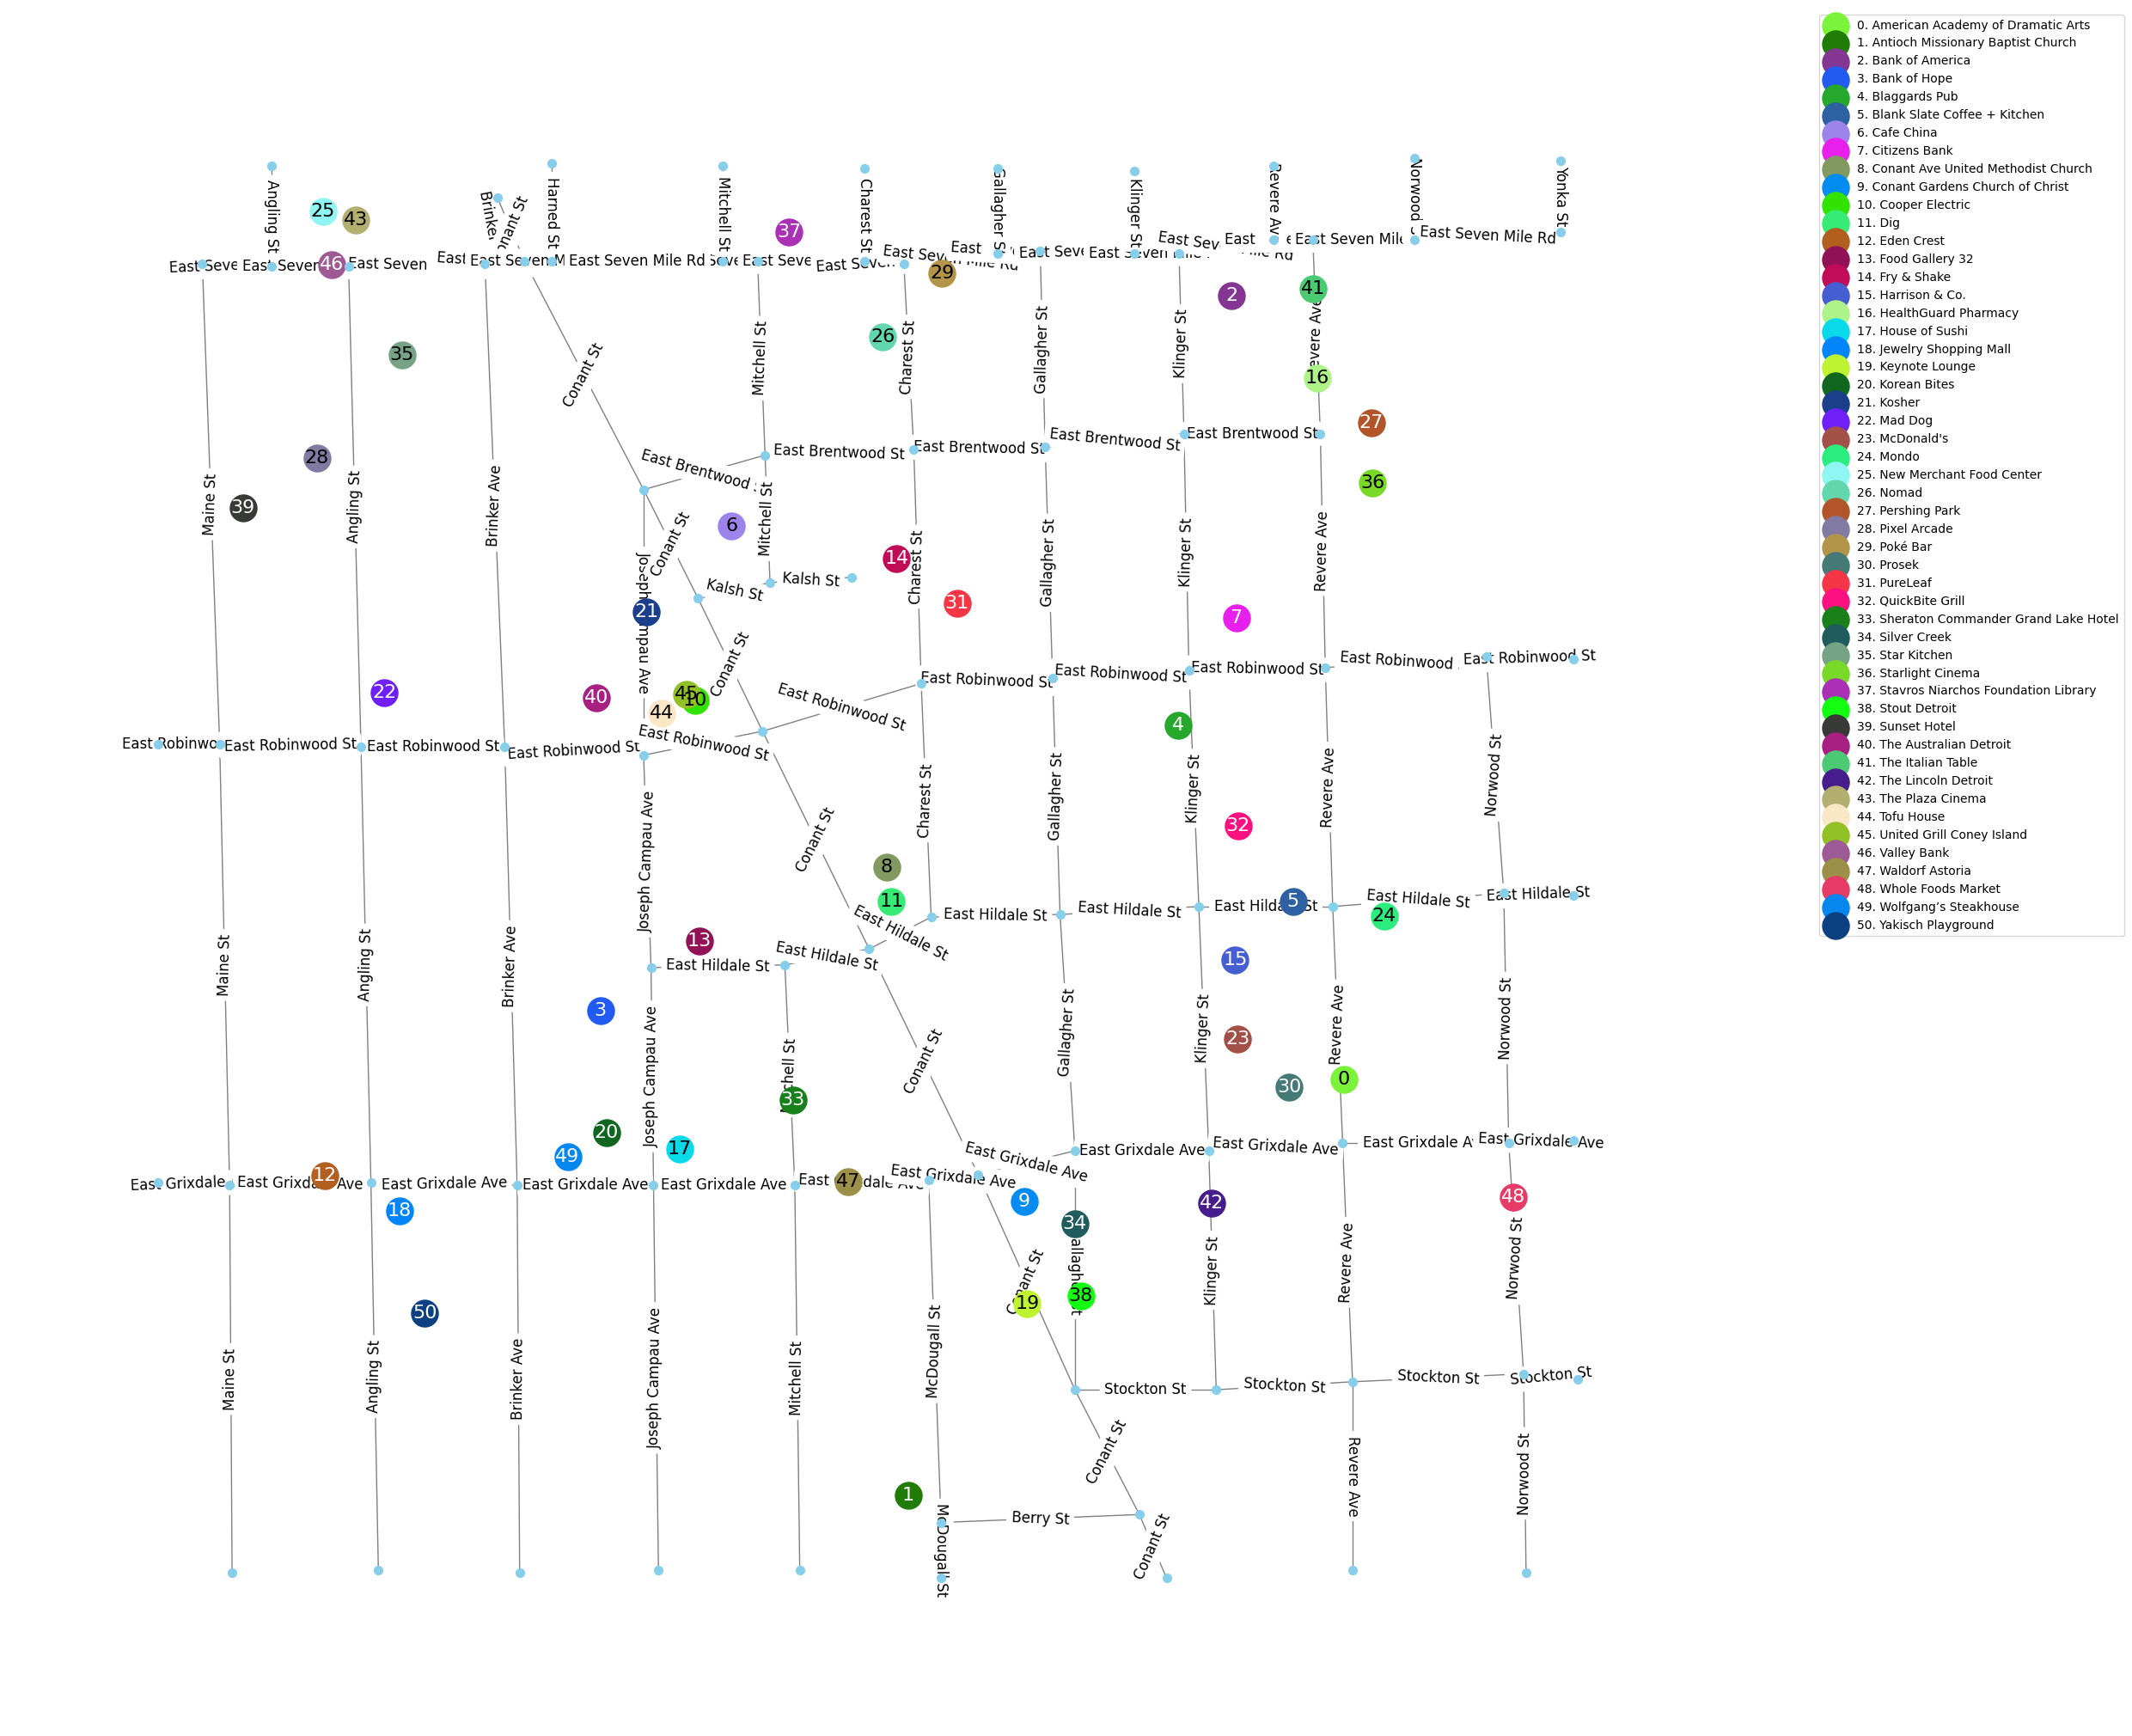

In [218]:
pos = nx.get_node_attributes(G, "pos")

plt.figure(figsize=(20, 20))

nx.draw(
    G,
    pos,
    #with_labels=True,
    node_size=50,
    node_color="skyblue",
    font_size=20,
    font_color="black",
    font_weight="bold",
    edge_color="gray",
)

labels = nx.get_edge_attributes(G, "street")
#labels = {k: round(v, 2) for k, v in labels.items()}
#labels = {k: get_label(v) for k, v in labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=12)

colors = np.random.rand(len(pois), 3)
for i, poi in enumerate(pois):
    coords = poi["coords"]
    dot = plt.scatter(
        coords[0], coords[1], color=colors[i], s=500, label=f"{i}. {poi['name']}"
    )
    text_color = get_contrasting_color(colors[i])
    plt.text(coords[0], coords[1], i, fontsize=16, c=text_color, ha="center", va="center")

plt.gca().invert_yaxis()
plt.gcf().set_size_inches(20, 20)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.savefig(f"{out}/plot.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

In [219]:
offset = 0
for i, poi in enumerate(pois[offset:]):
    print(f"{i + offset}. {poi['name']} - {edges[poi['edge']]}")

0. American Academy of Dramatic Arts - [45, 46]
1. Antioch Missionary Baptist Church - [25, 26]
2. Bank of America - [41, 42]
3. Bank of Hope - [14, 15]
4. Blaggards Pub - [34, 40]
5. Blank Slate Coffee + Kitchen - [46, 47]
6. Cafe China - [21, 22]
7. Citizens Bank - [40, 41]
8. Conant Ave United Methodist Church - [59, 61]
9. Conant Gardens Church of Christ - [31, 57]
10. Cooper Electric - [16, 17]
11. Dig - [27, 28]
12. Eden Crest - [1, 5]
13. Food Gallery 32 - [15, 16]
14. Fry & Shake - [28, 29]
15. Harrison & Co. - [38, 39]
16. HealthGuard Pharmacy - [48, 49]
17. House of Sushi - [14, 15]
18. Jewelry Shopping Mall - [4, 5]
19. Keynote Lounge - [31, 57]
20. Korean Bites - [14, 15]
21. Kosher - [63, 17]
22. Mad Dog - [6, 10]
23. McDonald's - [38, 39]
24. Mondo - [45, 46]
25. New Merchant Food Center - [65, 7]
26. Nomad - [29, 30]
27. Pershing Park - [48, 49]
28. Pixel Arcade - [6, 7]
29. Poké Bar - [29, 30]
30. Prosek - [45, 46]
31. PureLeaf - [28, 29]
32. QuickBite Grill - [39, 40]


In [220]:
edges[43]

[21, 22]